# EMSL Summer School
## Day 1 Afternoon Session: Machine Learning Examples
### Gradient Boosting Model for Predicting Soil Carbon Prediction
##### SOLUTION

## Problem Statement

**The Challenge:** Agricultural scientists, environmental researchers, and land managers need to predict soil carbon content from readily available soil and environmental measurements. Soil carbon is a critical indicator of:
- **Soil fertility**: Higher carbon content typically indicates more fertile soils
- **Carbon Storage**: Soil is a major $CO_2$ sink from the atmosphere
- **Ecosystem health**: Carbon content reflects soil biological activity and nutrient cycling
- **Agricultural productivity**: Carbon-rich soils support better crop yields and sustainable farming

Traditional soil carbon analysis requires expensive laboratory testing and time-consuming sample processing. Can we use machine learning to predict carbon content directly from other soil properties and environmental measurements?

**Your Dataset:** We're working with *real* EMSL data from the [Molecular Observation Network (MONet)](https://www.emsl.pnnl.gov/monet#mission) program (`merged_soil_data_expanded.csv`) that contains:
- Chemical properties (pH levels, nutrient concentrations, mineral content)
- Physical measurements (texture, moisture, density)
- Environmental factors (location, climate data, vegetation type)
- Sample metadata (collection methods, timing)
- **Target variable**: Soil carbon content (continuous values)

**Your Mission:** Build a Gradient Boosting regressor that can accurately predict soil carbon content from other soil properties. Gradient Boosting is an excellent algorithm for this task because it:
- Handles complex non-linear relationships between soil properties
- Provides feature importance rankings for scientific interpretation
- Is robust to outliers commonly found in environmental data
- Offers excellent predictive performance for continuous targets

We'll practice data preprocessing, model training, evaluation, and interpretation - skills essential for any machine learning project. By the end, you'll have a working regression model and understand which soil properties are most important for predicting carbon content.

**Learning Goals:**
- Master the regression machine learning workflow
- Understand Gradient Boosting for continuous predictions
- Interpret model results for scientific insights
- Apply best practices for regression model evaluation

## Load, Clean & Visualize your Data 

Let's start by exploring the dataset to understand what we're working with. We'll examine the carbon content we're trying to predict and get a sense of the soil properties that might help us make these predictions.

**Task:** Import appropriate libraries and load your dataframe using `read_csv`. Check the dimensions of the data, and explore the distribution of carbon content (our target variable). 

 **So that the regressor can run correctly, you will need to ensure there are no NA values in the `carbon` column AND ensure no feature columns are completely empty**. Gradient boosters are less flexible in their handling of missing values. Create visualizations to understand the relationships between carbon and potential predictor variables.

Dropped 7 completely empty columns
Dataset shape: (513, 119)

Column names:
['sample_name', 'mbc', 'mbn', 'flag_mbc', 'flag_mbn', 'density', 'carbon', 'nitrogen', 'kj_nitro', 'sulfur', 'enzyme', 'mz_percent', 'rms', 'hc_ratio', 'oc_ratio', 'c_ratio', 'dbe_average', 'water_content', 'sulfate', 'boron', 'zinc', 'manganate', 'copper', 'iron', 'calcium', 'magnesium', 'sodium', 'potassium', 'total_bases', 'cation_exchange_capacity', 'nh4n', 'no3n', 'flag_no3n', 'flag_nh4n', 'ph', 'phosphorus', 'extraction', 'flag_phosphorus', 'rate', 'flag_respiration', 'sand', 'silt', 'clay', 'toc.maom', 'toc.weom', 'tn.maom', 'tn.weom', 'flag_tn_maom.maom', 'roi_volume_voxel', 'voxel_size_um3', 'connected_pores_percent', 'pore_diameter_min_mm', 'pore_diameter_max_mm', 'pore_diameter_mean_mm', 'pore_diameter_median_mm', 'pore_diameter_variance_mm', 'pore_volume_mean_mm3', 'total_pore_volume_percent', 'permeability_x_um2', 'flow_rate_x_um3_per_sec', 'tortuosity_x', 'permeability_y_um2', 'flow_rate_y_um3_per

C:\Users\kapu336\AppData\Local\Temp\ipykernel_27424\4045607762.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lat_groups = [group['carbon'].values for name, group in df_lat_carbon.groupby('lat_bins') if len(group) > 0]
C:\Users\kapu336\AppData\Local\Temp\ipykernel_27424\4045607762.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(lat_groups, labels=lat_labels)


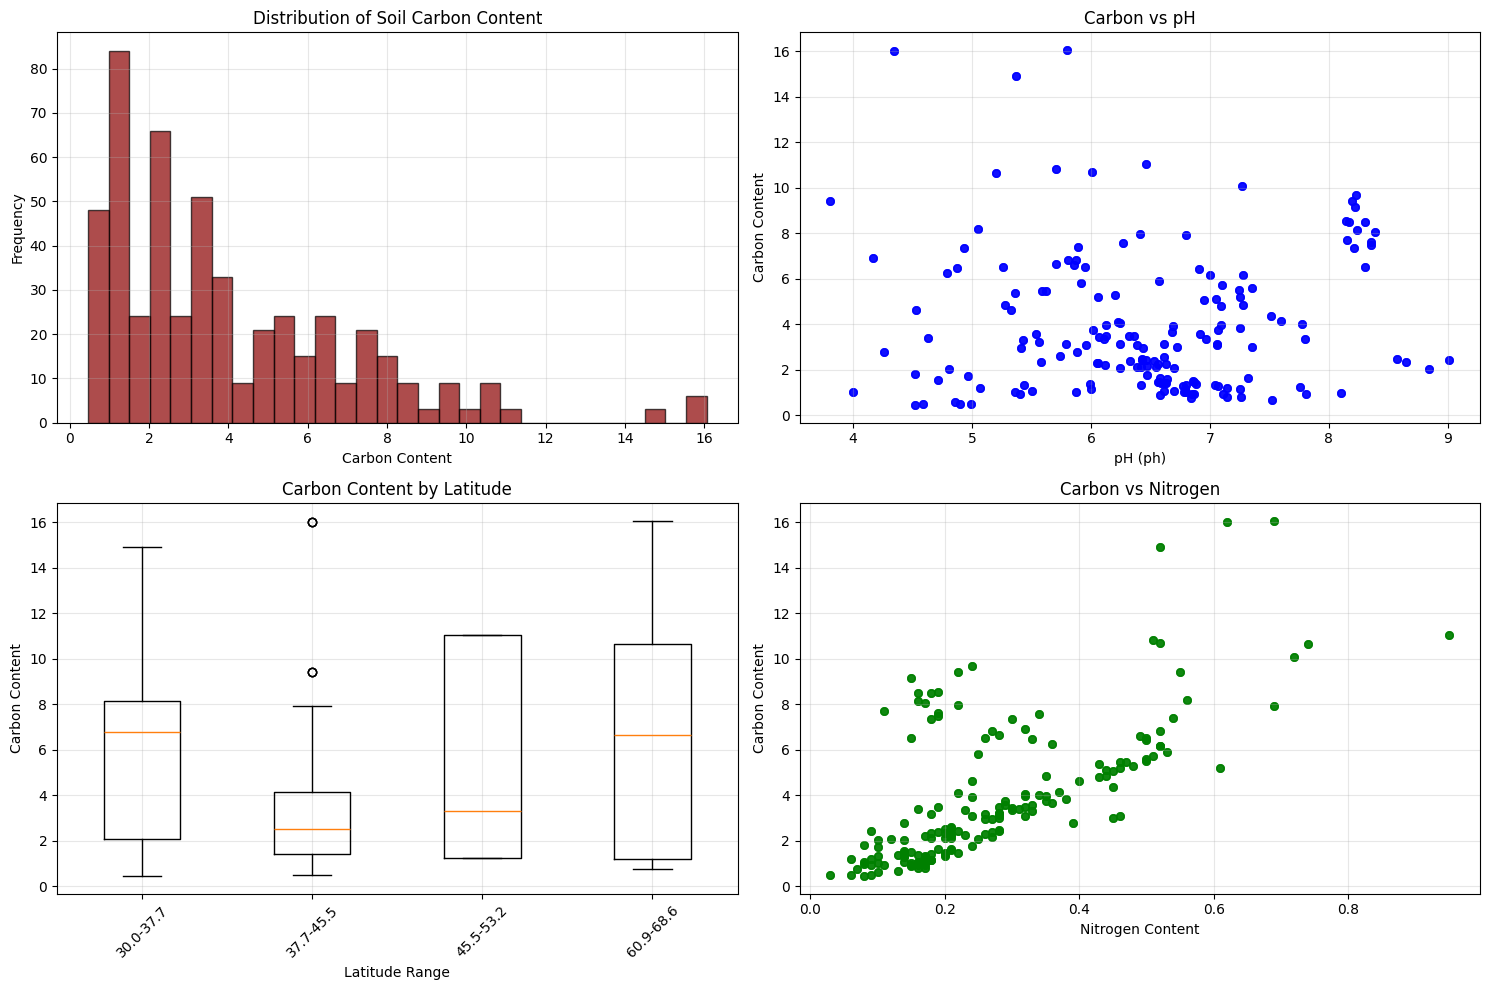


Missing values in key columns:
carbon               0
nitrogen             0
ph                   0
phosphorus           0
flag_phosphorus    312
latitude             0
dtype: int64

Carbon content statistics:
count    513.000000
mean       3.973275
std        3.067205
min        0.460000
25%        1.480000
50%        3.120000
75%        5.750000
max       16.060000
Name: carbon, dtype: float64


In [6]:
# Import libraries (pandas, numpy, matplotlib, seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data using read_csv from pandas
df = pd.read_csv('../data/merged_soil_data_expanded.csv')

# Remove rows where carbon is missing (do this first!)
df = df.dropna(subset=['carbon'])

# Drop completely empty feature columns (all NaN values)
initial_cols = df.shape[1]
df = df.dropna(axis=1, how='all')
final_cols = df.shape[1]
dropped_cols = initial_cols - final_cols
if dropped_cols > 0:
    print(f"Dropped {dropped_cols} completely empty columns")

print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

# Identify available soil properties (check what's actually in the data)
potential_ph_cols = [col for col in df.columns if 'ph' in col.lower()]
print(f"\nAvailable pH-related columns: {potential_ph_cols}")

soil_properties = ['carbon', 'nitrogen', 'calcium', 'magnesium', 'potassium', 
                  'phosphorus', 'sulfur', 'iron', 'manganese', 'zinc', 'copper', 'boron']
available_props = [prop for prop in soil_properties if prop in df.columns]
available_props.extend(potential_ph_cols)
print(f"\nAvailable soil properties: {available_props}")

# Create visualizations of carbon content and its relationships with other properties
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution of Carbon Content in data
ax1.hist(df['carbon'].dropna(), bins=30, alpha=0.7, color='darkred', edgecolor='black')
ax1.set_xlabel('Carbon Content')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Soil Carbon Content')
ax1.grid(True, alpha=0.3)

# 2. Scatterplot of Carbon vs pH relationship (use the first available pH column)
ph_col = potential_ph_cols[0] if potential_ph_cols else None
if ph_col:
    valid_data = df.dropna(subset=['carbon', ph_col])
    ax2.scatter(valid_data[ph_col], valid_data['carbon'], alpha=0.6, color='blue', s=30)
    ax2.set_xlabel(f'pH ({ph_col})')
    ax2.set_ylabel('Carbon Content')
    ax2.set_title('Carbon vs pH')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'pH data not available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Carbon vs pH (no pH data)')

# 3. Carbon vs Latitude (Box plot by latitude bins)
if 'latitude' in df.columns:
    # Create latitude bins for box plot
    df['lat_bins'] = pd.cut(df['latitude'], bins=5, precision=1)
    df_lat_carbon = df.dropna(subset=['carbon', 'lat_bins'])
    if len(df_lat_carbon) > 0:
        lat_groups = [group['carbon'].values for name, group in df_lat_carbon.groupby('lat_bins') if len(group) > 0]
        lat_labels = [f"{interval.left:.1f}-{interval.right:.1f}" for interval in df_lat_carbon['lat_bins'].cat.categories if not df_lat_carbon[df_lat_carbon['lat_bins'] == interval].empty]
        
        if lat_groups:
            ax3.boxplot(lat_groups, labels=lat_labels)
            ax3.set_xlabel('Latitude Range')
            ax3.set_ylabel('Carbon Content')
            ax3.set_title('Carbon Content by Latitude')
            ax3.tick_params(axis='x', rotation=45)
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'Insufficient latitude data', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Carbon vs Latitude (insufficient data)')
    else:
        ax3.text(0.5, 0.5, 'No valid latitude-carbon pairs', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Carbon vs Latitude (no data)')
else:
    ax3.text(0.5, 0.5, 'Latitude data not available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Carbon vs Latitude (no latitude data)')

# 4. Carbon vs Nitrogen relationship
if 'nitrogen' in df.columns:
    valid_cn = df.dropna(subset=['carbon', 'nitrogen'])
    if len(valid_cn) > 0:
        ax4.scatter(valid_cn['nitrogen'], valid_cn['carbon'], alpha=0.6, color='green', s=30)
        ax4.set_xlabel('Nitrogen Content')
        ax4.set_ylabel('Carbon Content')
        ax4.set_title('Carbon vs Nitrogen')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No valid carbon-nitrogen pairs', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Carbon vs Nitrogen (no data)')
else:
    ax4.text(0.5, 0.5, 'Nitrogen data not available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Carbon vs Nitrogen (no nitrogen data)')

plt.tight_layout()
plt.show()

# Check for missing values in key columns
print("\nMissing values in key columns:")
key_cols = ['carbon', 'nitrogen'] + potential_ph_cols + (['latitude'] if 'latitude' in df.columns else [])
if key_cols:
    print(df[key_cols].isnull().sum())

# Basic statistics for carbon using describe()
print(f"\nCarbon content statistics:")
print(df['carbon'].describe())

## Build Your Gradient Boosting Regressor

We are going to build & train a Gradient Boosting regression model. This is an excellent choice for environmental data because it can capture complex non-linear relationships, handles mixed data types well, and provides excellent predictive performance for continuous targets.

**Your Goal:** Create a Gradient Boosting regressor using `GradientBoostingRegressor` from `scikit-learn` that can predict soil carbon content from the metadata and observations contained in the EMSL MONet dataset. 

**Task:** Complete the Gradient Boosting implementation below. You'll need to do the following:
1. Prepare your data by **selecting numeric features** and handling missing values - start by focusing on features that might be related to soil carbon content
2. Split the data into training and testing sets 
3. Configure the Gradient Boosting model with appropriate hyperparameters
4. Train the model and make predictions
5. Evaluate performance using regression metrics (R², RMSE, MAE) and create visualizations

In [ ]:
# Import required libraries for machine learning
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import numpy as np

# Select only numeric columns for features (excluding our target 'carbon')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'carbon' in numeric_cols:
    numeric_cols.remove('carbon')  # Remove target variable from features

# Display the number of available numeric features
print(f"Available numeric features: {len(numeric_cols)} columns")
print("First 10 features:", numeric_cols[:10])

# Create our feature matrix (X) and target vector (y)
X = df[numeric_cols]
y = df['carbon']

print(f"Data shape: {X.shape}")
print(f"Missing values in features: {X.isnull().sum().sum()}")

# Handle missing values using SimpleImputer (fill with median)
# This example uses SimpleImputer; the classification task simply uses fill.na 
imputer = SimpleImputer(strategy='median')
X_filled = pd.DataFrame(
    imputer.fit_transform(X), 
    columns=X.columns,
    index=X.index
)

print(f"Count of missing values after imputation: {X_filled.isnull().sum().sum()}")

# Step 2: Split data into training and testing sets
print("\nStep 2: Splitting data into train/test sets")

X_train, X_test, y_train, y_test = train_test_split(
    X_filled, y,
    test_size=0.3,      # Use 30% for testing
    random_state=42     # For reproducible results
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Step 3: Create and configure the Gradient Boosting model with default hyperparameters
print("\nStep 3: Creating Gradient Boosting model")
gb_model = GradientBoostingRegressor(
    n_estimators=100,        # Number of boosting stages (trees)
    learning_rate=0.1,       # How much each tree contributes
    max_depth=3,             # Maximum depth of each tree
    random_state=42          # For reproducible results
)
 
# Step 4: Train the model using gb_model.fit
gb_model.fit(X_train, y_train)

# Step 5: Make predictions
y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)

# Step 6: Evaluate model performance
# Calculate r2, mse, mae metrics for training set
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

# Calculate r2, mse, mae metrics for test set
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("TRAINING SET PERFORMANCE:")
print(f"  R² Score: {train_r2:.3f}")
print(f"  RMSE: {train_rmse:.3f}")
print(f"  MAE: {train_mae:.3f}")

print("\nTEST SET PERFORMANCE:")
print(f"  R² Score: {test_r2:.3f}")
print(f"  RMSE: {test_rmse:.3f}")
print(f"  MAE: {test_mae:.3f}")

# Check for overfitting
performance_diff = train_r2 - test_r2
if performance_diff > 0.1:
    print(f"\nWarning: Possible overfitting detected (train R² - test R² = {performance_diff:.3f})")
else:
    print(f"\nGood news: Model shows consistent performance (train R² - test R² = {performance_diff:.3f})")

print("\n" + "="*50)
print("MODEL TRAINING COMPLETE!")
print("="*50)

Available numeric features: 90 columns
First 10 features: ['mbc', 'mbn', 'density', 'nitrogen', 'kj_nitro', 'sulfur', 'enzyme', 'mz_percent', 'rms', 'hc_ratio']
Data shape: (513, 90)
Missing values in features: 10041
Count of ,issing values after imputation: 0

Step 2: Splitting data into train/test sets
Training set size: 359 samples
Testing set size: 154 samples

Step 3: Creating Gradient Boosting model
TRAINING SET PERFORMANCE:
  R² Score: 0.999
  RMSE: 0.118
  MAE: 0.092

TEST SET PERFORMANCE:
  R² Score: 0.985
  RMSE: 0.341
  MAE: 0.218

Good news: Model shows consistent performance (train R² - test R² = 0.014)

MODEL TRAINING COMPLETE!
TRAINING SET PERFORMANCE:
  R² Score: 0.999
  RMSE: 0.118
  MAE: 0.092

TEST SET PERFORMANCE:
  R² Score: 0.985
  RMSE: 0.341
  MAE: 0.218

Good news: Model shows consistent performance (train R² - test R² = 0.014)

MODEL TRAINING COMPLETE!


## Visualize and Evaluate Your Regression Model

Now that we've trained our Gradient Boosting regressor, it's time to evaluate how well it performs and understand what drives its predictions. Regression evaluation focuses on how closely predicted values match actual values and understanding prediction errors.

**Task:** Create comprehensive visualizations to assess model performance and gain insights into which soil properties are most important for predicting carbon content.

**The Key Visualizations:**

1. **Predictions vs Actual Scatter Plot** - Shows how well predicted carbon values match actual carbon values. Points close to the diagonal line indicate good predictions, while scattered points show prediction errors.

2. **Residual Analysis Plot** - Displays the difference between predicted and actual values (residuals) to identify patterns in prediction errors and check model assumptions.

3. **Feature Importance Bar Chart** - Shows which soil properties are most important for predicting carbon content. Higher importance values indicate features that contribute more to the model's predictions.

4. **Regression Metrics Summary** - Provides quantitative measures of model performance:
   - **R² Score**: Proportion of variance explained by the model (closer to 1.0 is better)
   - **RMSE (Root Mean Square Error)**: Average prediction error in the same units as carbon content (lower is better)
   - **MAE (Mean Absolute Error)**: Average absolute prediction error (lower is better)


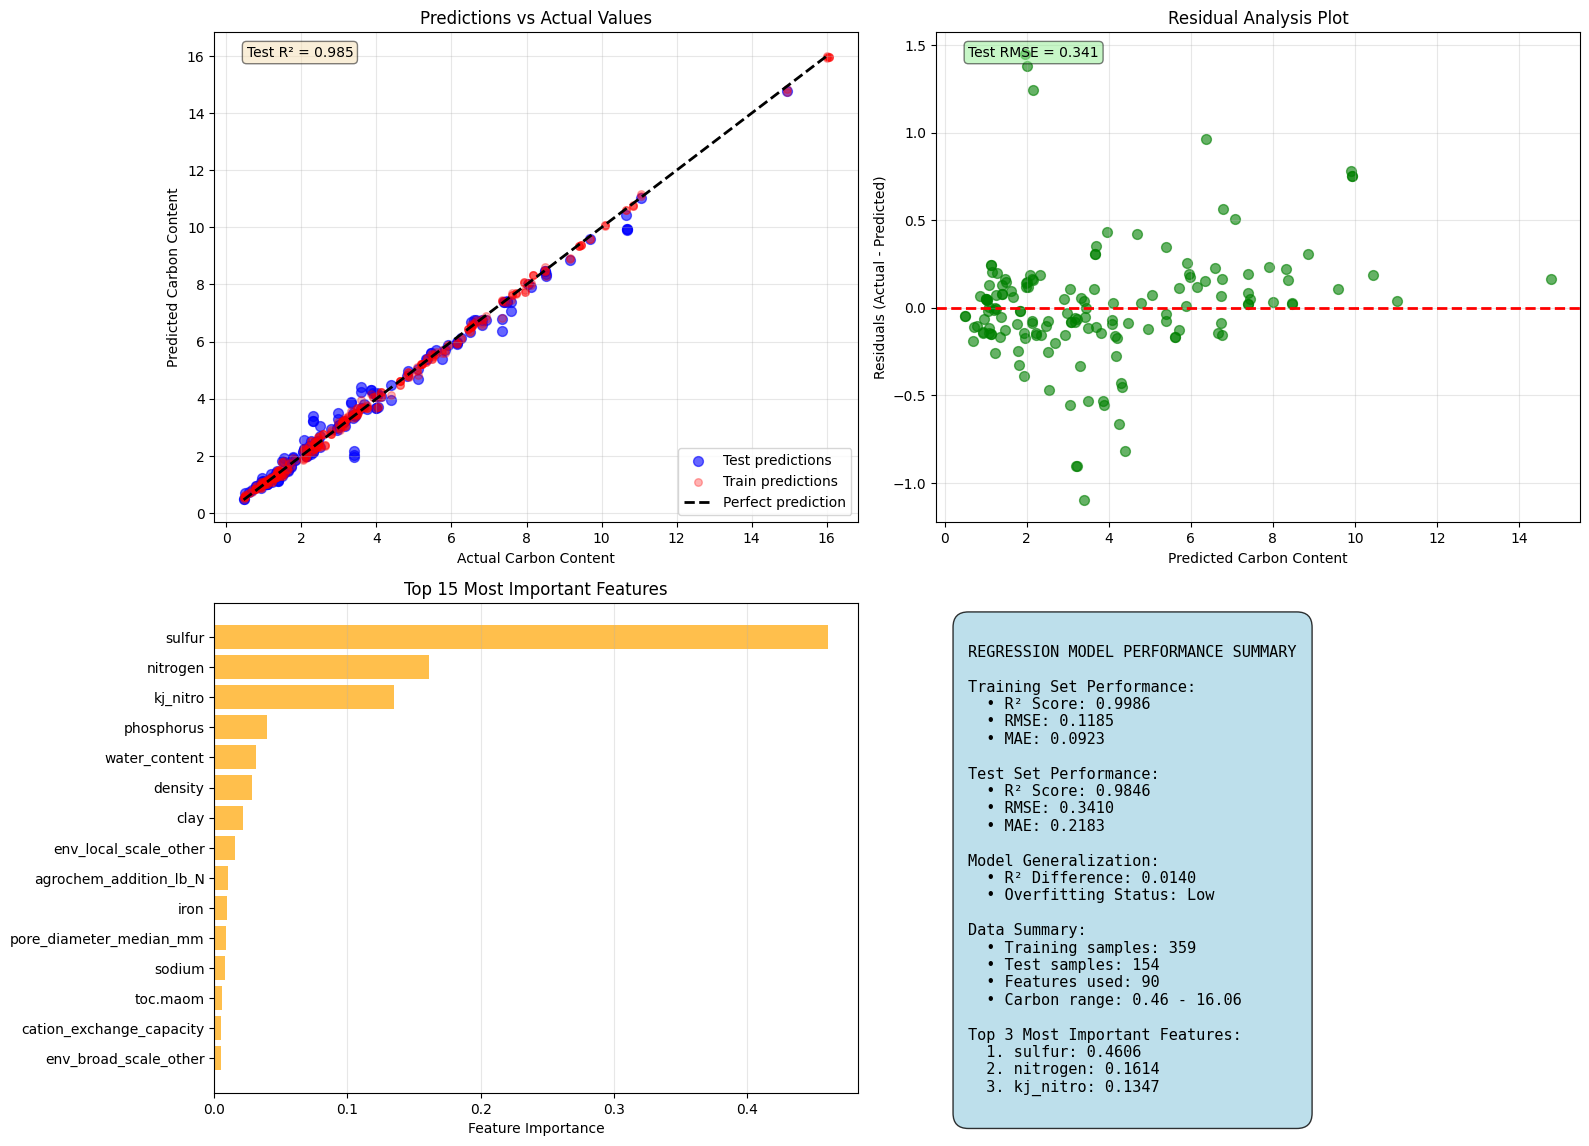

REGRESSION MODEL EVALUATION COMPLETE

Model Interpretation:
• The model explains 98.5% of carbon content variation
• Average prediction error: 0.341 carbon units
• Most important predictor: sulfur
• ✅ EXCELLENT: Model shows strong predictive performance
• ✅ LOW OVERFITTING: Model generalizes well to new data

Scientific Insights:
• Key soil carbon predictors identified
• Model can guide soil management decisions
• Useful for carbon sequestration planning


In [8]:
# Create comprehensive regression evaluation visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predictions vs Actual Carbon Content Scatter Plot
ax1.scatter(y_test, y_test_pred, alpha=0.6, color='blue', s=50, label='Test predictions')
ax1.scatter(y_train, y_train_pred, alpha=0.3, color='red', s=30, label='Train predictions')

# Add perfect prediction line (diagonal)
min_val = min(y_test.min(), y_train.min())
max_val = max(y_test.max(), y_train.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect prediction')

ax1.set_xlabel('Actual Carbon Content')
ax1.set_ylabel('Predicted Carbon Content')
ax1.set_title('Predictions vs Actual Values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add R² annotation to the plot
ax1.text(0.05, 0.95, f'Test R² = {test_r2:.3f}', transform=ax1.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residuals Plot (Prediction Errors)
residuals_test = y_test - y_test_pred
ax2.scatter(y_test_pred, residuals_test, alpha=0.6, color='green', s=50)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted Carbon Content')
ax2.set_ylabel('Residuals (Actual - Predicted)')
ax2.set_title('Residual Analysis Plot')
ax2.grid(True, alpha=0.3)

# Add RMSE annotation
ax2.text(0.05, 0.95, f'Test RMSE = {test_rmse:.3f}', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# 3. Feature Importance Bar Chart (Top 15 features)
feature_importance = gb_model.feature_importances_
feature_names = X_filled.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

top_features = importance_df.head(15)
ax3.barh(range(len(top_features)), top_features['importance'], color='orange', alpha=0.7)
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(top_features['feature'], fontsize=10)
ax3.set_xlabel('Feature Importance')
ax3.set_title('Top 15 Most Important Features')
ax3.grid(True, alpha=0.3, axis='x')

# Reverse y-axis to show most important at top
ax3.invert_yaxis()

# 4. Model Performance Metrics Summary
ax4.axis('off')  # Turn off axis for text display

# Create a summary table of metrics
metrics_text = f"""
REGRESSION MODEL PERFORMANCE SUMMARY

Training Set Performance:
  • R² Score: {train_r2:.4f}
  • RMSE: {train_rmse:.4f}
  • MAE: {train_mae:.4f}

Test Set Performance:
  • R² Score: {test_r2:.4f}
  • RMSE: {test_rmse:.4f}
  • MAE: {test_mae:.4f}

Model Generalization:
  • R² Difference: {performance_diff:.4f}
  • Overfitting Status: {'Low' if performance_diff < 0.1 else 'Moderate' if performance_diff < 0.2 else 'High'}

Data Summary:
  • Training samples: {X_train.shape[0]:,}
  • Test samples: {X_test.shape[0]:,}
  • Features used: {X_filled.shape[1]:,}
  • Carbon range: {y.min():.2f} - {y.max():.2f}

Top 3 Most Important Features:
  1. {top_features.iloc[0]['feature']}: {top_features.iloc[0]['importance']:.4f}
  2. {top_features.iloc[1]['feature']}: {top_features.iloc[1]['importance']:.4f}
  3. {top_features.iloc[2]['feature']}: {top_features.iloc[2]['importance']:.4f}
"""

ax4.text(0.05, 0.95, metrics_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional insights
print("="*60)
print("REGRESSION MODEL EVALUATION COMPLETE")
print("="*60)

print(f"\nModel Interpretation:")
print(f"• The model explains {test_r2:.1%} of carbon content variation")
print(f"• Average prediction error: {test_rmse:.3f} carbon units")
print(f"• Most important predictor: {top_features.iloc[0]['feature']}")

if test_r2 > 0.7:
    print(f"• ✅ EXCELLENT: Model shows strong predictive performance")
elif test_r2 > 0.5:
    print(f"• ✅ GOOD: Model shows solid predictive performance")
elif test_r2 > 0.3:
    print(f"• ⚠️  MODERATE: Model shows reasonable but limited performance")
else:
    print(f"• ❌ POOR: Model shows weak predictive performance")

if performance_diff < 0.1:
    print(f"• ✅ LOW OVERFITTING: Model generalizes well to new data")
else:
    print(f"• ⚠️  OVERFITTING DETECTED: Model may not generalize well")

print(f"\nScientific Insights:")
print(f"• Key soil carbon predictors identified")
print(f"• Model can guide soil management decisions")
print(f"• Useful for carbon sequestration planning")

## Interpretation and Next Steps

You've built and evaluated a Gradient Boosting regressor for predicting soil carbon content from other soil properties. Now let's think about how to improve your model and what your results tell us about the machine learning process.

### Food for Thought

**Model Performance Analysis:**
- What was your R² score? How does this compare to a baseline model that always predicts the mean?
- What was your RMSE? How does this compare to the standard deviation of your target variable?
- Do your residuals show any patterns, or are they randomly distributed around zero? What does this tell you about model assumptions?
- Is there evidence of overfitting? How do training vs test performance compare?

**Feature Engineering & Selection:**
- Which soil properties were most important for predictions? Were there any surprising results?
- How many features did you use? What would happen if you only used the top 10 most important features?
- Are there features with very low importance that you could remove to simplify your model?
- Could you create new features by combining existing ones (e.g., ratios, polynomial terms, interactions)?

**Model Tuning & Experimentation:**
- How did your hyperparameters (n_estimators, learning_rate, max_depth) affect performance? Try adjusting them!
- What happens if you use different train/test split ratios or random seeds?
- How does your model perform with different missing value strategies (mean vs median vs forward-fill)?
- Could you improve performance by feature scaling or normalization?

**Regression-Specific Considerations:**
- Are you satisfied with your R² score, or do you need higher precision for your use case?
- How does RMSE vs MAE tell different stories about your prediction errors?
- Are there outliers significantly affecting your model performance?
- What does the residual plot tell you about model bias or heteroscedasticity?

**Real-World ML Considerations:**
- How would you validate this model on completely new data to ensure generalizability?
- What would you do if you encountered carbon values outside your training range?
- How would you monitor model performance over time and decide when to retrain?
- What are the trade-offs between model complexity and interpretability for your use case?

### Next Steps for Model Improvement
- **Hyperparameter optimization**: Use GridSearchCV or RandomizedSearchCV to tune Gradient Boosting parameters
- **Feature engineering**: Create polynomial features, interaction terms, or domain-specific transformations
- **Algorithm comparison**: Test other regressors (Random Forest, SVR, Linear Regression, Neural Networks) on the same data
- **Ensemble methods**: Combine multiple models using voting or stacking for potentially better performance
- **Cross-validation**: Use k-fold cross-validation for more robust performance estimates
- **Outlier analysis**: Identify and handle outliers that might be skewing your predictions
- **Feature selection**: Use techniques like recursive feature elimination or LASSO regularization

The key to successful regression modeling is systematic experimentation - try different approaches, measure their impact quantitatively, and iterate based on your performance metrics!